<a href="https://colab.research.google.com/github/Nam-gu/MLB_Prediction/blob/main/1980_2019dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn import metrics
import statsmodels.api as sm
from sklearn.metrics import accuracy_score
import lightgbm
from lightgbm import LGBMClassifier
from sklearn import svm
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

from google.colab import drive
drive.mount('/content/drive')

base=['NYY', 'MIN', 'CLE', 'DET', 'SEA', 'TOR', 'SD', 'CHC', 'STL', 'SF', 'COL', 'MIA',
 'LAD', 'PHI' ,'BAL', 'OAK', 'BOS', 'PIT', 'WAS', 'ATL' ,'TB', 'TEX' ,'KC' ,'CWS',
 'MIL', 'CIN' ,'HOU', 'LAA', 'NYM', 'ARI']

file = 'drive/MyDrive/data/Retrosheet_2010_2019/1980_to_2019_seasons.csv'
game_df = pd.read_csv(file)

game_col_del = '''VisitorGDP,VisitorCI,HomeGDP,HomeCI, DoubleHeader, DayOfWeek, VisitingTeamLeague, HomeTeamLeague, DayNight, CompletionInfo,ForfeitInfo, ProtestInfo,Duration, VisitorLineScore, HomeLineScore, UmpireHID, UmpireHName, Umpire1BID, Umpire1BName, Umpire2BID,Umpire2BName, Umpire3BID, Umpire3BName, UmpireLFID, UmpireLFName, UmpireRFID,UmpireRFName, VisitorManagerID, VisitorManagerName, HomeManagerID, HomeManagerName,WinningPitcherID, WinningPitcherName, LosingPitcherID, LosingPitcherNAme,SavingPitcherID, SavingPitcherName, GameWinningRBIID, GameWinningRBIName, VisitorBatting1Position, VisitorBatting2Position, VisitorBatting3Position,VisitorBatting4Position, VisitorBatting5Position, VisitorBatting6Position,VisitorBatting7Position, VisitorBatting8Position, VisitorBatting9Position,HomeBatting1Position, HomeBatting2Position, HomeBatting3Position,HomeBatting4Position, HomeBatting5Position, HomeBatting6Position,HomeBatting7Position, HomeBatting8Position, HomeBatting9Position,AdditionalInfo, AcquisitionInfo'''
game_col_del = game_col_del.replace(" ", "")
game_col_del = game_col_del.split(",")

game_df.drop(game_col_del,axis=1,inplace=True)




my_attendence={'BOS':37755, 'LAA':45517, 'CWS':40615, 'KC':37903, 'OAK':56782, 'TEX':40300, 'ARI':48686, 'ATL':41084, 'CIN':42319,
       'HOU':41168, 'MIL':41900, 'NYM':41922, 'PIT':38747, 'WAS':41339, 'TB':42735, 'BAL':44970, 'DET':41083, 'COL':50144,
       'MIA':37442, 'SF':41265, 'CLE':34830, 'MIN':38544, 'SEA':47929, 'TOR':49282, 'CHC':41649, 'PHI':42792, 'SD':40209, 'STL':45494,
       'NYY':54251, 'LAD':56000}
# Had an extra team due to the Marlins having two different labels. Updating their team name to MIA

game_df.replace(to_replace='FLO', value='MIA', inplace=True)

# Updating game_df so team abbreviations match. Will be leveraged when aggregating teams stats
game_df.replace(to_replace={"NYA":"NYY", "SDN":"SD", "CHN":"CHC", "SLN":"STL", "SFN":"SF", "LAN":"LAD", "TBA":"TB", "KCA":"KC", "CHA":"CWS", "ANA":"LAA", "NYN":"NYM"}, inplace=True)



# totalname=set(game_df['VisitingTeam'].unique())
# print(len(totalname))
# print(len(base))
# base=set(base)
# exceptname=totalname - base
# print(exceptname)
# input()
# print(ttt)

#{'MON', 'CAL'} 빼야 하는 팀

indexNames = game_df[ game_df['VisitingTeam'] == 'MON' ].index
# Delete these row indexes from dataFrame
game_df.drop(indexNames , inplace=True)
indexNames = game_df[ game_df['VisitingTeam'] == 'CAL' ].index
# Delete these row indexes from dataFrame
game_df.drop(indexNames , inplace=True)
indexNames = game_df[ game_df['HomeTeam'] == 'MON' ].index
# Delete these row indexes from dataFrame
game_df.drop(indexNames , inplace=True)
indexNames = game_df[ game_df['HomeTeam'] == 'CAL' ].index
# Delete these row indexes from dataFrame
game_df.drop(indexNames , inplace=True)

for key, value in my_attendence.items():
  game_df.loc[game_df['HomeTeam']==key,'Attendence']=game_df.loc[game_df['HomeTeam']==key,'Attendence']/value


file4 = 'drive/MyDrive/data/park_factors.csv'
parkfactor_df = pd.read_csv(file4, encoding='cp949')
parkfactor_df

# Had an extra team due to the Marlins having two different labels. Updating their team name to MIA
parkfactor_df.replace(to_replace='FLO', value='MIA', inplace=True)

# Updating game_df so team abbreviations match. Will be leveraged when aggregating teams stats
parkfactor_df.replace(to_replace={"NYA":"NYY", "SDN":"SD", "CHN":"CHC", "SLN":"STL", "SFN":"SF", "LAN":"LAD", "TBA":"TB", "KCA":"KC", "CHA":"CWS", "ANA":"LAA", "NYN":"NYM"}, inplace=True)


game_df = pd.merge(game_df, parkfactor_df, on="HomeTeam")

col_del = ['VisitorBatting1PlayerID', 'VisitorBatting1Name', 'VisitorBatting2PlayerID', 'VisitorBatting2Name', 'VisitorBatting3PlayerID', 'VisitorBatting3Name', 'VisitorBatting4PlayerID', 'VisitorBatting4Name', 'VisitorBatting5PlayerID', 'VisitorBatting5Name', 'VisitorBatting6PlayerID', 'VisitorBatting6Name', 'VisitorBatting7PlayerID', 'VisitorBatting7Name', 'VisitorBatting8PlayerID', 'VisitorBatting8Name', 'VisitorBatting9PlayerID', 'VisitorBatting9Name', 'HomeBatting1PlayerID', 'HomeBatting1Name', 'HomeBatting2PlayerID', 'HomeBatting2Name', 'HomeBatting3PlayerID', 'HomeBatting3Name', 'HomeBatting4PlayerID', 'HomeBatting4Name', 'HomeBatting5PlayerID', 'HomeBatting5Name', 'HomeBatting6PlayerID', 'HomeBatting6Name', 'HomeBatting7PlayerID', 'HomeBatting7Name', 'HomeBatting8PlayerID', 'HomeBatting8Name', 'HomeBatting9PlayerID', 'HomeBatting9Name']
game_df.drop(col_del,axis=1,inplace=True)
game_df = game_df.rename(columns={"VisitingTeam":"VisitorTeam","VisitingTeamGameNumber":"VisitorTeamGameNumber"})

game_df['Date'] = pd.to_datetime(game_df['Date'].astype(str), format='%Y%m%d')
game_df['current_year'] = game_df['Date'].dt.year

game_df['prior_year']=game_df['current_year']-1
print(game_df.Attendence)
trend=1 #몇일 롤링
game_df[f'{trend}d_home_attendance'] = game_df.groupby(['current_year', 'HomeTeam'])['Attendence'].transform(lambda x: round(x.rolling(trend).mean().shift(periods=1, axis=0), 3))
print(game_df[f'{trend}d_home_attendance'])

away_inning = game_df['LengthInOuts']//2
home_inning = game_df['LengthInOuts']- away_inning


game_df['VisitorOffInn'] = away_inning
game_df['VisitorDifInn'] = home_inning
game_df['HomeOffInn'] = home_inning
game_df['HomeDifInn'] = away_inning

game_df['Home_team_won?'] = game_df['HomeRunsScore'] > game_df['VisitorRunsScored']
game_df['Visitor_team_won?'] = game_df['HomeRunsScore'] < game_df['VisitorRunsScored']

bat_stat = [ 'TeamGameNumber','Team','AB','H','D','T','HR','RBI','SH','SF',
'HBP','BB','IBB','K','SB','CS','LOB','Pitchers',
'ER','TER','WP','Balks','PO','A','E','Passed','DB','TP','OffInn','DifInn','_team_won?']
pit_stat = ['H', 'D', 'T', 'HR', 'RBI', 'SH', 'SF', 'HBP', 'BB', 'IBB', 'K', 'LOB', 'ER','DB','AB']

select_stat = ['Date']
select_stat += ['Home'+i for i in bat_stat]+['Visitor'+i for i in pit_stat]
rename1 = {'Visitor'+i:'Pit'+i for i in pit_stat}
rename2 = {'Home'+i:i for i in bat_stat}

## Home 시각 
select_stat = ['Date']
select_stat += ['Home'+i for i in bat_stat]+['Visitor'+i for i in pit_stat]
rename1 = {'Visitor'+i:'Pit'+i for i in pit_stat}
rename2 = {'Home'+i:i for i in bat_stat}
Home = game_df.copy()
Home = Home[select_stat].rename(columns=rename1)
Home = Home.rename(columns=rename2)
# away 시각
select_stat = ['Date']
select_stat += ['Visitor'+i for i in bat_stat]+['Home'+i for i in pit_stat]
rename1 = {'Home'+i:'Pit'+i for i in pit_stat}
rename2 = {'Visitor'+i:i for i in bat_stat}
Visitor = game_df.copy()
Visitor = Visitor[select_stat].rename(columns=rename1)
Visitor = Visitor.rename(columns=rename2)

sep_team = pd.concat([Home,Visitor])
sep_team = sep_team.rename(columns={'PitDB':'DP'})
sep_team

col = ['AB', 'H', 'D', 'T', 'HR', 'RBI','DP',
       'SF', 'BB', 'K', 'SB', 'CS', 'LOB', 'Pitchers', 'ER', 'TER', 'WP','PitAB',
       'Balks', 'PO', 'A', 'E', 'Passed', 'DB', 'TP', 'OffInn', 'DifInn',
       'PitH', 'PitD', 'PitT', 'PitHR', 'PitRBI', 'PitSF',
       'PitBB', 'PitK', 'PitLOB', 'PitER']



a = sep_team.copy()
sep_team['year']= sep_team.Date.dt.year
print(sep_team.groupby(['year','Team'])[col])



sep_team[col] = sep_team.groupby(['year','Team'])[col].transform(lambda x: x.expanding(1).sum())
sep_team[col] = sep_team[col].subtract(a[col])
sep_team = sep_team[sep_team['TeamGameNumber']>=10] #최소 10경기 이상
sep_team

select_feature = ['Date', 'TeamGameNumber', 'Team','_team_won?']
# feature selection
select_feature += ['AB', 'H', 'D', 'T', 'HR', 'RBI','BB', 'K','DP', 'HBP','IBB','SF','SH',#bat stat
                    'ER','OffInn','DifInn' # game info
                    ,'PitAB','PitH', 'PitD', 'PitT', 'PitHR', 'PitRBI', 'PitSF', 'PitBB',"PitIBB","PitHBP" ,'PitK','PitLOB', 'PitER'
                    ]
sep = sep_team[select_feature] 
# H, OBP, SLG, ISO, Babip, RC, wOBA X, K, BB, RBI, K/B, HR   
# 타자 가공
sep['RC'] = ((sep['H']+sep['BB']+sep['HBP']-sep['DP'])
        *(sep['H']+2*sep['D']+3*sep['T']+4*sep['HR']+0.52*(sep['SF']+sep['SH'])+0.26*(sep['BB']+sep['HBP']-sep['IBB']))
        )/(sep['AB']*sep['AB']) #득점 생산


#사구,사사구, 고의사구 통합
sep['BB'] += sep['HBP']+sep['IBB']
sep['PitBB'] += sep['PitHBP']+sep['PitIBB']
#del sep['HBP'],sep['IBB'],sep['PitHBP'],sep['PitIBB']
# 희생번트, 희생플라이 통합
sep['PitSF'] += sep_team['PitSH']
sep['SF'] += sep['SH']
#del sep['SH'],sep['PitSH']

sep['K/B'] = sep['K']/(sep['BB']+0.5)
sep['PA'] = sep['AB'] - sep['BB'] - sep['SF'] # 타수
sep['Babip'] = (sep['H']+sep['D']+sep['T']) / (sep['PA']-sep['K']-sep['HR']-sep['SF']) # 인플레이 타구
sep['SLG'] = (sep['H']+2*sep['D']+3*sep['T']+4*sep['HR'])/sep['PA'] # 장타율
sep['H'] = sep['H']/sep['PA'] # 안타율
sep['D'] = sep['D']/sep['PA'] # 안타율
sep['T'] = sep['T']/sep['PA'] # 안타율
sep['HR'] = sep['HR']/sep['PA'] # 안타율
sep['BB'] = sep['BB']/sep['PA'] # 볼넷
sep['K'] = sep['K']/sep['PA'] # 볼넷
sep['RBI'] = sep['RBI']/sep['TeamGameNumber'] # 득점

sep['OBP'] = (sep['H']+sep['BB']) #출루율
sep['OPS'] = sep['SLG']+sep['OBP'] #OPS
sep['GPA'] = (1.8*sep['OBP']+sep['SLG'])/4#GPA(Gross Production Average) - park factor를 적용해야함
sep['ISO'] = sep['SLG'] - sep['H']
# 투수 가공
# PitH, PitOBP, PitSLG, PitOPS, PitHR, EAR, PitB, PitK, PitK/B, WHIP, kwERA
sep['ERA'] = sep['PitER']/sep['DifInn']
sep['TotalH'] = sep['PitH']+sep['PitD']+sep['PitT']+sep['PitHR']
sep['TotalBB'] = sep['PitBB']+sep['PitHBP']
sep['PitPA'] = sep['PitAB'] - sep['TotalBB'] - sep['PitSF']
sep['kwERA'] = (5.40-12*(sep['PitK'] - sep['TotalBB']))/sep['PitPA']
sep['WHIP'] = (sep['TotalH']+sep['TotalBB'])/sep['DifInn']
sep['PitK'] = sep['PitK']/sep['DifInn']
sep['PitB'] = sep['TotalBB']/sep['DifInn']
sep['PitK/B'] = sep['PitK']/(sep['PitB']+0.5)


sep['PitSLG'] = (sep['PitH']+2*sep['PitD']+3*sep['PitT']+4*sep['PitHR'])/sep['PitPA'] # 피장타율
sep['PitH'] = sep['PitH']/sep['PitPA'] # 피안타율
sep['PitOBP'] = (sep['TotalH']+sep['TotalBB']) / sep['PitAB'] #피출루율
sep['PitOPS'] = sep['PitSLG']+sep['PitOBP'] #피OPS
sep['PitHR'] /= sep['PitPA']

#ParkFactors

temp = sep
game_log = game_df[['Date','VisitorTeam','HomeTeam','VisitorTeamGameNumber','HomeTeamGameNumber',f'{trend}d_home_attendance','ParkFactors']]

game_log = game_log[game_log.VisitorTeamGameNumber>=10]
game_log = game_log[game_log.HomeTeamGameNumber>=10]



game_log = pd.merge(game_log,temp,left_on = ['Date','VisitorTeam'], right_on = ['Date','Team'],how='left')
game_log = pd.merge(game_log,temp,left_on = ['Date','HomeTeam'], right_on = ['Date','Team'],how='left')

game_log['year'] = game_log.Date.dt.year

train = game_log[game_log.year!=2019]
test = game_log[game_log.year==2019]

y_cols = ['_team_won?_x']
select = ['H','OBP','SLG','ISO','Babip','RC','K','BB','RBI','K/B','HR','PitH','PitOBP','PitSLG','PitOPS','PitHR','ERA','PitB','PitK','PitK/B','WHIP']
#select = ['H', 'D', 'T', 'HR', 'RBI', 'BB']
x_cols = [i+'_x' for i in select]
x_cols += [i+'_y' for i in select]
train = train.dropna()
test = test.dropna()

x_cols += [f'{trend}d_home_attendance']
x_cols += ['ParkFactors']

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
0        0.471280
1        0.127355
2        0.141313
3        0.095287
4        0.114044
           ...   
83950    0.534386
83951    0.538305
83952    0.663635
83953    0.929752
83954    0.889330
Name: Attendence, Length: 83955, dtype: float64
0          NaN
1        0.471
2        0.127
3        0.141
4        0.095
         ...  
83950    0.537
83951    0.534
83952    0.538
83953    0.664
83954    0.930
Name: 1d_home_attendance, Length: 83955, dtype: float64


In [ ]:
'''
    Z-score normalization
'''
scaler = StandardScaler()
scaler.fit(train[x_cols])
X_train = scaler.transform(train[x_cols])
X_test = scaler.transform(test[x_cols])

In [18]:
X_train = train[x_cols]
y_train = train[y_cols]*1

X_test = test[x_cols]
y_test = test[y_cols]*1



In [ ]:
X_train

,H_x,OBP_x,SLG_x,ISO_x,Babip_x,RC_x,K_x,BB_x,RBI_x,K/B_x,...,PitSLG_y,PitOPS_y,PitHR_y,ERA_y,PitB_y,PitK_y,PitK/B_y,WHIP_y,1d_home_attendance,ParkFactors
0,0.280959,0.427430,0.554816,0.273857,0.504551,0.179534,0.272082,0.146471,33.700000,1.854766,...,0.640449,1.149883,0.044944,0.146341,0.195122,0.195122,0.280702,0.658537,1.013,1.063
1,0.278481,0.423832,0.550415,0.271934,0.500000,0.176896,0.272370,0.145351,30.909091,1.871064,...,0.535433,0.970807,0.039370,0.110169,0.161017,0.228814,0.346154,0.542373,0.982,1.063
2,0.277155,0.422414,0.550000,0.272845,0.500000,0.176261,0.273707,0.145259,28.750000,1.881481,...,0.532051,0.957466,0.038462,0.124138,0.158621,0.262069,0.397906,0.531034,0.981,1.063
3,0.277067,0.423274,0.552003,0.274936,0.500000,0.176786,0.273231,0.146206,27.076923,1.866084,...,0.560440,1.001754,0.043956,0.110465,0.168605,0.255814,0.382609,0.546512,0.984,1.063
4,0.322424,0.429899,0.598384,0.275960,0.498421,0.202908,0.183030,0.107475,31.076923,1.699812,...,0.611374,1.087181,0.042654,0.105528,0.175879,0.246231,0.364312,0.592965,0.996,1.063
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24385,0.285483,0.387325,0.592833,0.307350,0.521844,0.181896,0.278396,0.101842,4.894737,2.730884,...,0.507270,0.893872,0.036349,0.153131,0.090509,0.362035,0.613090,0.505382,0.885,0.905
24386,0.259783,0.355460,0.509732,0.249949,0.483417,0.144400,0.305265,0.095677,3.740260,3.187166,...,0.502192,0.885556,0.035871,0.153697,0.089415,0.365394,0.619926,0.501208,0.895,0.905
24387,0.259825,0.355936,0.510283,0.250458,0.483510,0.144853,0.305233,0.096111,3.748387,3.172487,...,0.503546,0.888077,0.036249,0.153149,0.091126,0.364981,0.617433,0.502863,0.937,0.905
24388,0.259551,0.354760,0.509400,0.249848,0.482556,0.144393,0.305235,0.095209,3.737179,3.202545,...,0.501748,0.884450,0.036117,0.154644,0.089109,0.365865,0.621048,0.500707,0.956,0.905


In [20]:
y_train

,_team_won?_x
0,0
1,1
2,1
3,1
4,0
...,...
86844,0
86845,1
86846,0
86847,0


In [19]:
model = sm.Logit(y_train,X_train)
results = model.fit()
print(results.summary())

y_hat = results.predict( X_train)
y_hat = list(map(round,y_hat))
print('Train accuracy = ', accuracy_score(y_train, y_hat))

y_hat = results.predict( X_test)
y_hat = list(map(round,y_hat))
print('Test accuracy = ', accuracy_score(y_test, y_hat))

Optimization terminated successfully.
         Current function value: 0.679853
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:           _team_won?_x   No. Observations:                84431
Model:                          Logit   Df Residuals:                    84393
Method:                           MLE   Df Model:                           37
Date:                Sat, 14 May 2022   Pseudo R-squ.:                 0.01433
Time:                        18:08:56   Log-Likelihood:                -57401.
converged:                       True   LL-Null:                       -58235.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
H_x                    1.1087   4.37e+05   2.54e-06      1.000   -8.56e+05    8.56e+05
OBP_x

In [ ]:
num_thread = 8
# num of cpu 
param ={'num_leaves':[4,6,8,10,20],'max_depth':[-1,3,6,9,12,15]}
lgb =LGBMClassifier()
lgb_clf = GridSearchCV(lgb,param,scoring='accuracy',n_jobs=num_thread)
lgb_results = lgb_clf.fit(X_train, y_train.values.ravel(), eval_metric=['logloss'],eval_set=[(X_test, y_test.values.ravel())],callbacks=[lightgbm.early_stopping(0, verbose=0)])

train_score = lgb_results.score(X_train, y_train)
test_score = lgb_results.score(X_test, y_test)
print(lgb_results.best_params_)
print(test_score)



[1]	valid_0's binary_logloss: 0.689655
[2]	valid_0's binary_logloss: 0.688711
[3]	valid_0's binary_logloss: 0.68761
[4]	valid_0's binary_logloss: 0.686368
[5]	valid_0's binary_logloss: 0.685587
[6]	valid_0's binary_logloss: 0.684723
[7]	valid_0's binary_logloss: 0.684231
[8]	valid_0's binary_logloss: 0.684032
[9]	valid_0's binary_logloss: 0.682867
[10]	valid_0's binary_logloss: 0.681975
[11]	valid_0's binary_logloss: 0.681336
[12]	valid_0's binary_logloss: 0.680472
[13]	valid_0's binary_logloss: 0.679823
[14]	valid_0's binary_logloss: 0.679087
[15]	valid_0's binary_logloss: 0.678627
[16]	valid_0's binary_logloss: 0.678342
[17]	valid_0's binary_logloss: 0.677898
[18]	valid_0's binary_logloss: 0.677316
[19]	valid_0's binary_logloss: 0.676848
[20]	valid_0's binary_logloss: 0.67665
[21]	valid_0's binary_logloss: 0.676365
[22]	valid_0's binary_logloss: 0.675905
[23]	valid_0's binary_logloss: 0.675556
[24]	valid_0's binary_logloss: 0.674956
[25]	valid_0's binary_logloss: 0.674799
[26]	valid_

In [ ]:
rf_param ={'min_samples_split':[4,6,8,10,20],'max_depth':[-1,3,6,9,12,15]}
rf =RandomForestClassifier()
rf_clf = GridSearchCV(rf,rf_param,scoring='accuracy',n_jobs=num_thread)
rf_results = rf_clf.fit(X_train,  y_train.values.ravel())


train_score = rf_results.score(X_train, y_train)
test_score = rf_results.score(X_test, y_test)
print(rf_results.best_params_)
print(test_score)

param_range = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0] 
svm_param  = [{'C': param_range, 'kernel': ['linear']}, {'C': param_range, 'gamma': param_range, 'kernel': ['rbf']}]
svm_model =svm.SVC()
svm_clf = GridSearchCV(estimator=svm_model,param_grid=svm_param,scoring='accuracy',n_jobs=num_thread,verbose=0)
svm_results = svm_clf.fit(X_train, y_train.values.ravel())

train_score = svm_results.score(X_train, y_train)
test_score = svm_results.score(X_test, y_test)
print(svm_results.best_params_)
print(test_score)

In [ ]:
# Requirements:
!pip install rtdl
!pip install libzero==0.0.4

from typing import Any, Dict

import numpy as np
import rtdl
import scipy.special
import sklearn.datasets
import sklearn.metrics
import sklearn.model_selection
import sklearn.preprocessing
import torch
import torch.nn as nn
import torch.nn.functional as F
import zero

#device = torch.device('cpu')

device = torch.device("cuda:0")
# Docs: https://yura52.github.io/zero/0.0.4/reference/api/zero.improve_reproducibility.html
zero.improve_reproducibility(seed=123456)

123456

In [ ]:
# !!! NOTE !!! The dataset splits, preprocessing and other details are
# significantly different from those used in the
# paper "Revisiting Deep Learning Models for Tabular Data",
# so the results will be different from the reported in the paper.

dataset = sklearn.datasets.fetch_california_housing()
task_type = 'regression'

# dataset = sklearn.datasets.fetch_covtype()
# task_type = 'multiclass'

assert task_type in ['binclass', 'multiclass', 'regression']

X_all = dataset['data'].astype('float32')
y_all = dataset['target'].astype('float32' if task_type == 'regression' else 'int64')
if task_type != 'regression':
    y_all = sklearn.preprocessing.LabelEncoder().fit_transform(y_all).astype('int64')
n_classes = int(max(y_all)) + 1 if task_type == 'multiclass' else None

X = {}
y = {}
X['train'], X['test'], y['train'], y['test'] = sklearn.model_selection.train_test_split(
    X_all, y_all, train_size=0.8
)
X['train'], X['val'], y['train'], y['val'] = sklearn.model_selection.train_test_split(
    X['train'], y['train'], train_size=0.8
)

# not the best way to preprocess features, but enough for the demonstration
preprocess = sklearn.preprocessing.StandardScaler().fit(X['train'])
X = {
    k: torch.tensor(preprocess.fit_transform(v), device=device)
    for k, v in X.items()
}
y = {k: torch.tensor(v, device=device) for k, v in y.items()}

# !!! CRUCIAL for neural networks when solving regression problems !!!
if task_type == 'regression':
    y_mean = y['train'].mean().item()
    y_std = y['train'].std().item()
    y = {k: (v - y_mean) / y_std for k, v in y.items()}
else:
    y_std = y_mean = None

if task_type != 'multiclass':
    y = {k: v.float() for k, v in y.items()}

In [ ]:
X_train.shape

X = {}
y = {}

# X_train = train[x_cols]
# y_train = train[y_cols]*1

# X_test = test[x_cols]
# y_test = test[y_cols]*1
print(y_train)
y_train = sklearn.preprocessing.LabelEncoder().fit_transform(y_train).astype('int64')
y_test = sklearn.preprocessing.LabelEncoder().fit_transform(y_test).astype('int64')

print(y_train)

X['train']=X_train
X['test']=X_test
y['train']=y_train
y['test']=y_test


# not the best way to preprocess features, but enough for the demonstration
preprocess = sklearn.preprocessing.StandardScaler().fit(X['train'])
X = {
    k: torch.tensor(preprocess.fit_transform(v), device=device)
    for k, v in X.items()
}
y = {k: torch.tensor(v, device=device) for k, v in y.items()}

print(X_train)
X['train']=torch.tensor(X['train'],dtype=torch.float32)
X['test']=torch.tensor(X['test'],dtype=torch.float32)
X['train']

X['train'], X['val'], y['train'], y['val'] = sklearn.model_selection.train_test_split(
    X['train'], y['train'], train_size=0.8
)

       _team_won?_x
0                 1
1                 1
2                 1
3                 1
4                 0
...             ...
24385             0
24386             1
24387             0
24388             0
24389             0

[21978 rows x 1 columns]
[1 1 1 ... 0 0 0]
            H_x     OBP_x     SLG_x     ISO_x   Babip_x      RC_x       K_x  \
0      0.280959  0.427430  0.554816  0.273857  0.504551  0.179534  0.272082   
1      0.278481  0.423832  0.550415  0.271934  0.500000  0.176896  0.272370   
2      0.277155  0.422414  0.550000  0.272845  0.500000  0.176261  0.273707   
3      0.277067  0.423274  0.552003  0.274936  0.500000  0.176786  0.273231   
4      0.322424  0.429899  0.598384  0.275960  0.498421  0.202908  0.183030   
...         ...       ...       ...       ...       ...       ...       ...   
24385  0.285483  0.387325  0.592833  0.307350  0.521844  0.181896  0.278396   
24386  0.259783  0.355460  0.509732  0.249949  0.483417  0.144400  0.305265   
24387

In [ ]:
task_type ='binclass'
d_out = 1

# model = rtdl.MLP.make_baseline(
#     d_in=X_train.shape[1],
#     d_layers=[128, 256, 128],
#     dropout=0.1,
#     d_out=d_out,
# )
# lr = 0.001
# weight_decay = 0.0

model = rtdl.ResNet.make_baseline(
    d_in=X_train.shape[1],
    d_main=32,
    d_hidden=128,
    dropout_first=0.2,
    dropout_second=0.0,
    n_blocks=2,
    d_out=d_out,
)
lr = 0.0005
weight_decay = 0.0

# model = rtdl.FTTransformer.make_default(
#     n_num_features=X_all.shape[1],
#     cat_cardinalities=None,
#     last_layer_query_idx=[-1],  # it makes the model faster and does NOT affect its output
#     d_out=d_out,
# )

# === ABOUT CATEGORICAL FEATURES ===
# IF you use MLP, ResNet or any other simple feed-forward model (NOT transformer-based model)
# AND there are categorical features
# THEN you have to implement a wrapper that handles categorical features.
# The example below demonstrates how it can be achieved using rtdl.CategoricalFeatureTokenizer.
# ==================================
# 1. When you have both numerical and categorical features, you should prepare you data like this:
#    (X_num<float32>, X_cat<int64>) instead of X<float32>
#    Each column in X_cat should contain values within the range from 0 to <(the number of unique values in column) - 1>;
#    use sklean.preprocessing.OrdinalEncoder to achieve this;
# 2. Prepare a list of so called "cardinalities":
#    cardinalities[i] = <the number of unique values of the i-th categorical feature>
# 3. See the commented example below and adapt it for your needs.
#
# class Model(nn.Module):
#     def __init__(
#         self,
#         n_num_features: int,
#         cat_tokenizer: rtdl.CategoricalFeatureTokenizer,
#         mlp_kwargs: Dict[str, Any],
#     ):
#         super().__init__()
#         self.cat_tokenizer = cat_tokenizer
#         self.model = rtdl.MLP.make_baseline(
#             d_in=n_num_features + cat_tokenizer.n_tokens * cat_tokenizer.d_token,
#             **mlp_kwargs,
#         )
#
#     def forward(self, x_num, x_cat):
#         return self.model(
#             torch.cat([x_num, self.cat_tokenizer(x_cat).flatten(1, -1)], dim=1)
#         )
#
# model = Model(
#     # `None` means "Do not transform numerical features"
#     # `d_token` is the size of embedding for ONE categorical feature
#     X_num_all.shape[1],
#     rtdl.CategoricalFeatureTokenizer(cardinalities, d_token, True, 'uniform'),
#     mlp_kwargs,
# )
# Then the model should be used as `model(x_num, x_cat)` instead of of `model(x)`.

model.to(device)
# optimizer = (
#     model.make_default_optimizer()
#     if isinstance(model, rtdl.FTTransformer)
#     else torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
# )
optimizer=torch.optim.SGD(model.parameters(),lr=0.001)
loss_fn = (
    F.binary_cross_entropy_with_logits
    if task_type == 'binclass'
    else F.cross_entropy
    if task_type == 'multiclass'
    else F.mse_loss
)

In [ ]:
print(model)

ResNet(
  (first_layer): Linear(in_features=44, out_features=128, bias=True)
  (blocks): Sequential(
    (0): Block(
      (normalization): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (linear_first): Linear(in_features=128, out_features=256, bias=True)
      (activation): ReLU()
      (dropout_first): Dropout(p=0.2, inplace=False)
      (linear_second): Linear(in_features=256, out_features=128, bias=True)
      (dropout_second): Dropout(p=0.0, inplace=False)
    )
    (1): Block(
      (normalization): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (linear_first): Linear(in_features=128, out_features=256, bias=True)
      (activation): ReLU()
      (dropout_first): Dropout(p=0.2, inplace=False)
      (linear_second): Linear(in_features=256, out_features=128, bias=True)
      (dropout_second): Dropout(p=0.0, inplace=False)
    )
  )
  (head): Head(
    (normalization): BatchNorm1d(128, eps=1e-05, momentum

In [ ]:
def apply_model(x_num, x_cat=None):
    if isinstance(model, rtdl.FTTransformer):
        return model(x_num, x_cat)
    elif isinstance(model, (rtdl.MLP, rtdl.ResNet)):
        assert x_cat is None
        return model(x_num)
    else:
        raise NotImplementedError(
            f'Looks like you are using a custom model: {type(model)}.'
            ' Then you have to implement this branch first.'
        )


@torch.no_grad()
def evaluate(part):
    model.eval()
    prediction = []
    for batch in zero.iter_batches(X[part], 1024):
        prediction.append(apply_model(batch))
    prediction = torch.cat(prediction).squeeze(1).cpu().numpy()
    target = y[part].cpu().numpy()

    if task_type == 'binclass':
        prediction = np.round(scipy.special.expit(prediction))
        score = sklearn.metrics.accuracy_score(target, prediction)
    elif task_type == 'multiclass':
        prediction = prediction.argmax(1)
        score = sklearn.metrics.accuracy_score(target, prediction)
    else:
        assert task_type == 'regression'
        score = sklearn.metrics.mean_squared_error(target, prediction) ** 0.5 * y_std
    return score


# Create a dataloader for batches of indices
# Docs: https://yura52.github.io/zero/reference/api/zero.data.IndexLoader.html
batch_size = 1024
train_loader = zero.data.IndexLoader(len(X['train']), batch_size, device=device)

# Create a progress tracker for early stopping
# Docs: https://yura52.github.io/zero/reference/api/zero.ProgressTracker.html
progress = zero.ProgressTracker(patience=100)

print(f'Test score before training: {evaluate("test"):.4f}')

Test score before training: 0.5675


In [ ]:
n_epochs = 100000
report_frequency = len(X['train']) // batch_size // 5
myloss=[]
mytestaccuracy=[]
mytrainaccuracy=[]
len_trainloader=len(train_loader)
for epoch in range(1, n_epochs + 1):
    avg_loss=0
    for iteration, batch_idx in enumerate(train_loader):
        model.train()
        optimizer.zero_grad()
        x_batch = X['train'][batch_idx]
        y_batch = y['train'][batch_idx]
        loss = loss_fn(apply_model(x_batch).squeeze(1), y_batch.float())
        loss.backward()
        optimizer.step()
        avg_loss += loss.item()
    avg_loss=avg_loss / len_trainloader
    myloss.append(avg_loss)
    train_score = evaluate('train')
    mytrainaccuracy.append(train_score)
    test_score = evaluate('test')
    mytestaccuracy.append(test_score)
    print(f'Epoch {epoch:03d} | loss: {avg_loss:.4f} | Validation score: {train_score:.4f} | Test score: {test_score:.4f}')
    # progress.update((-1 if task_type == 'regression' else 1) * val_score)
    # if progress.success:
    #     print(' <<< BEST VALIDATION EPOCH', end='')
    # print()
    # if progress.fail:
    #     break

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
Epoch 95001 | loss: 0.4205 | Validation score: 0.8373 | Test score: 0.5578
Epoch 95002 | loss: 0.4234 | Validation score: 0.8361 | Test score: 0.5574
Epoch 95003 | loss: 0.4260 | Validation score: 0.8372 | Test score: 0.5582
Epoch 95004 | loss: 0.4257 | Validation score: 0.8388 | Test score: 0.5550
Epoch 95005 | loss: 0.4253 | Validation score: 0.8372 | Test score: 0.5574
Epoch 95006 | loss: 0.4246 | Validation score: 0.8362 | Test score: 0.5558
Epoch 95007 | loss: 0.4224 | Validation score: 0.8369 | Test score: 0.5590
Epoch 95008 | loss: 0.4246 | Validation score: 0.8360 | Test score: 0.5538
Epoch 95009 | loss: 0.4265 | Validation score: 0.8358 | Test score: 0.5518
Epoch 95010 | loss: 0.4256 | Validation score: 0.8371 | Test score: 0.5493
Epoch 95011 | loss: 0.4274 | Validation score: 0.8382 | Test score: 0.5554
Epoch 95012 | loss: 0.4295 | Validation score: 0.8388 | Test score: 0.5554
Epoch 95013 | loss: 0.4292 | Validation score: 0.8378 | Test sco

In [ ]:
import torch
import numpy as np
import torchvision.datasets as dataset
import torchvision.transforms as transforms
from torchvision import utils
import matplotlib.pyplot as plt




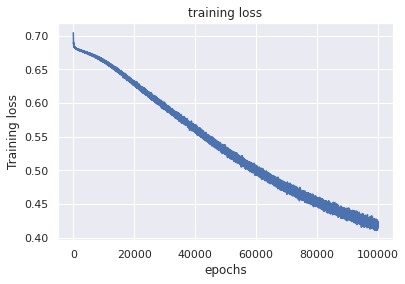

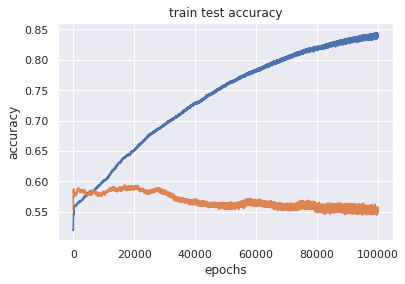

In [ ]:
epoch_graph=np.arange(1,100001)

plt.plot(epoch_graph,myloss)
plt.title('training loss')
plt.xlabel('epochs')
plt.ylabel('Training loss')
plt.show()



plt.plot(epoch_graph,mytrainaccuracy)

plt.plot(epoch_graph,mytestaccuracy)
plt.title('train test accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()